In [48]:
import numpy as np
import json
import os
import matplotlib.pyplot as plt
import urllib.request
import urllib.parse
import csv


In [23]:
def fix_gender_errors(content):
    spurious_records_gender = []
    good_records_gender = []
    for item_str in content:
        item = json.loads(item_str)
        if (item['gender'] != item['predicted_gender']):
            spurious_records_gender.append(item)
        else:
            item['final_gender'] = item['gender']
            good_records_gender.append(item)
    return good_records_gender,spurious_records_gender

def removeTBDs(content):
    spurious_records = []
    good_records = []
    for item in content:
        if (item['age'] == 'TBD' and item['predicted_age'] == 'TBD'):
            spurious_records.append(item)
        elif item['age'] == 'TBD':
            item['final_age'] = int(float(item['predicted_age']))
            good_records.append(item)
        elif item['predicted_gender'] =='TBD':
            item['final_age'] = int(float(item['age']))
            good_records.append(item)
        elif (item['age'] != 'TBD' and item['predicted_age'] != 'TBD'):
            age = int(float(item['age']))
            predicted_age = int(float(item['predicted_age']))
            if predicted_age < 16:
                item['final_age'] = age
            elif abs(age-predicted_age) <= 5 :
                item['final_age'] = (age + predicted_age)//2
            elif abs(age-predicted_age) > 5 :
                #Take the younger one
                item['final_age'] = min(age,predicted_age)
            good_records.append(item)
    
    for item in good_records:
        if (item['final_age'] > 70):
            spurious_records.append(item)
            good_records.remove(item)
    return good_records,spurious_records

In [24]:
#First do gender fixes on cricbuzz
with open('../../sports_cleaned_predicted.json') as f:
    content = f.readlines()
    content = [x.strip() for x in content]
    good_records_gender_cricbuzz,spurious_records_gender_cricbuzz = fix_gender_errors(content)
#Next do gender fixes on cricau
with open('../../sports_cleaned_cricau_predicted.json') as f:
    content = f.readlines()
    content = [x.strip() for x in content]
    good_records_gender_cricau,spurious_records_gender_cricau = fix_gender_errors(content)

In [25]:
#Remove ages where both predicted and original ages are TBD
good_records_tbd_removed_cricbuzz,spurious_records_tbd_cricbuzz = removeTBDs(good_records_gender_cricbuzz)
good_records_tbd_removed_cricau,spurious_records_tbd_cricau = removeTBDs(good_records_gender_cricau)
final_list = good_records_tbd_removed_cricbuzz + good_records_tbd_removed_cricau

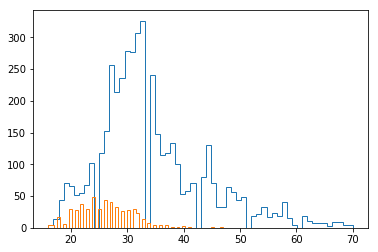

In [26]:
countmale = []
countfemale = []
for item in final_list:
    if item['final_gender'] == "M":
        countmale.append(item['final_age'])
    else:
        countfemale.append(item['final_age'])
plt.hist(countmale, bins=60,histtype='step')  # arguments are passed to np.histogram
plt.hist(countfemale, bins=60,histtype='step')
plt.show()

In [28]:
max_value = max(countmale)
min_value = min(countmale)
print ("Range of Male Ages")
print(max_value)
print(min_value)

print ("Range of Female Ages")
max_value = max(countfemale)
min_value = min(countfemale)
print(max_value)
print(min_value)

Range of Male Ages
70
16
Range of Female Ages
47
16


In [33]:
os.makedirs("FinalData")
with open('./FinalData/sports_final.json', 'w') as outfile:
    json.dump(final_list, outfile)

In [41]:
#Generate the images as they are
def download_img(img_url, file_name):
    full_path = './FinalData/Images/' + file_name
    encoded_url = urllib.parse.quote(img_url)
    encoded_url = encoded_url.replace("%3A",":")
    urllib.request.urlretrieve(encoded_url,full_path)

os.makedirs("FinalData/Images")
csv_contents_image_gender = []
csv_contents_image_age = []
with open('./FinalData/sports_final.json') as f:
    data = json.load(f)
    for item in data:
        img_url = item['img_url']
        file_name = item['name'] + '_' + item['final_gender'] + '_' + str(item['final_age']) + '.jpg'
        download_img(img_url,file_name)
        file_name_partial = 'Images/' + file_name
        age = item['final_age']
        if (item['gender'] == 'M'):
            gender = "male"
        elif (item['gender'] == 'F'):
            gender = "female"
        partial_entry_file_gender = {'name' : file_name_partial, 'gender' : gender}
        partial_entry_file_age = {'name' : file_name_partial, 'age' : age}
        csv_contents_image_gender.append(partial_entry_file_gender)
        csv_contents_image_age.append(partial_entry_file_age)


In [56]:
def csv_write(dictobj,filename):
    keys = dictobj[0].keys()
    print (keys)
    with open(filename, 'w') as output_file:
        dict_writer = csv.DictWriter(output_file, keys)
        dict_writer.writeheader()
        dict_writer.writerows(dictobj)

csv_write(csv_contents_image_gender,'FinalData/sports_clean_gender_list.csv')
csv_write(csv_contents_image_age,'FinalData/sports_clean_age_list.csv')
# for dictObject in csv_contents_image_age:
#     csv_write(dictObj,'FinalData/sports_clean_age_list.csv')

dict_keys(['name', 'gender'])
dict_keys(['name', 'age'])
